In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from include import enhanceContrast

In [2]:
# plot result
def plot_res(img, img_eq, name1, name2):

    # plotting for orignal image        
    hist, bins = np.histogram(img.flatten(), 256)
    pdf = hist / np.prod(img.shape)
    plt.figure(figsize=(12,10))
    plt.subplot(2, 2, 1)
    plt.plot(pdf, color='r')
    plt.title(name1)
    plt.xlim([0, 256])
    plt.ylim([0, pdf.max()+0.005])
    plt.subplot(2, 2, 2)
    plt.imshow(img, cmap="gray")

    # plotting for equalizated image
    hist2, bin2 = np.histogram(img_eq, 256)
    pdf2 = hist2 / np.prod(img.shape)
    plt.subplot(2, 2, 3)
    plt.plot(pdf2, color='r')
    plt.title(name2)
    plt.xlim([0, 256])
    plt.ylim([0, pdf2.max()+0.005])    
    plt.subplot(2, 2, 4)   
    plt.imshow(img_eq, cmap="gray")


# plot hist of a image
def plot_hist(img):
    
    plt.hist(img.flatten(), 256)

### Example 1

In [3]:
img1 = cv2.imread('a.jpg', 0)

In [4]:
enhanceContrast = enhanceContrast.enhanceContrast()

In [5]:
img1_he = enhanceContrast.basic_HE(img1)

In [6]:
img1_bhe = enhanceContrast.BHE(img1)

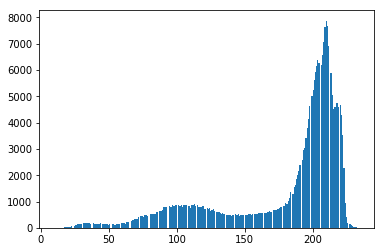

In [7]:
plot_hist(img1)

In [8]:
# 根据上面的 hist 图来选择限制的高度

limit = 2500 
img1_che = enhanceContrast.clipped_HE(img1, limit)

In [9]:
img1_bhepl = enhanceContrast.BHEPL(img1)

In [10]:
img1_ahe = enhanceContrast.adaptive_HE(img1)

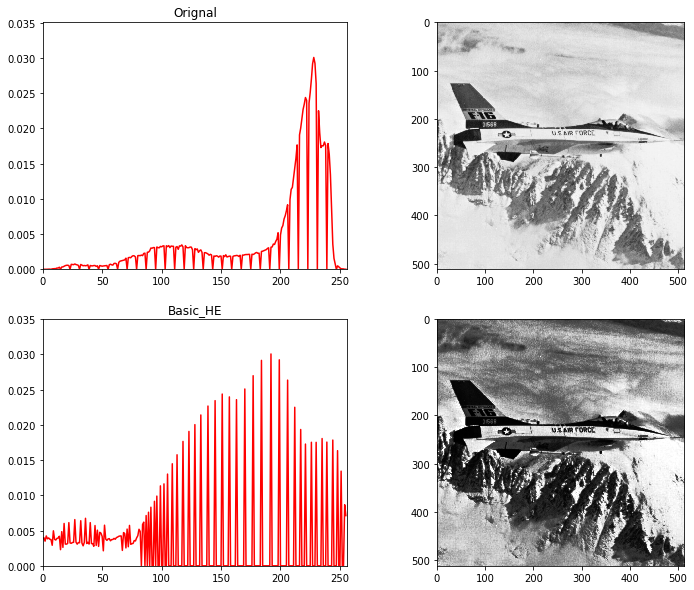

In [11]:
plot_res(img1, img1_he, "Orignal", "Basic_HE")

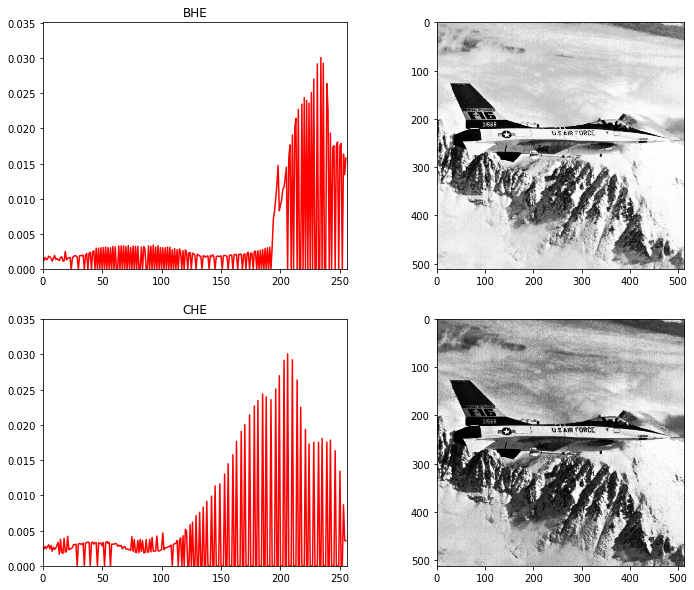

In [12]:
plot_res(img1_bhe, img1_che, "BHE", "CHE")

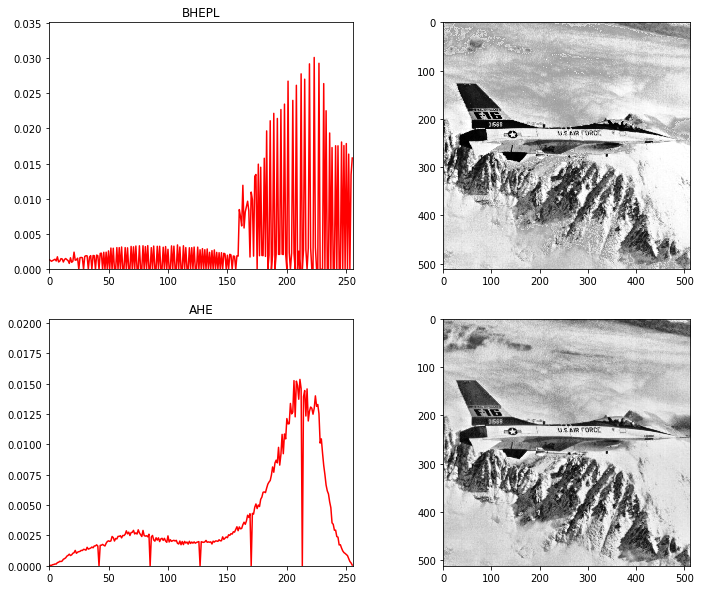

In [13]:
plot_res(img1_bhepl, img1_ahe, "BHEPL", "AHE")

### Example 2

In [14]:
img2 = cv2.imread('couple.jpg', 0)

In [15]:
img2_he = enhanceContrast.basic_HE(img2)

In [16]:
img2_bhe = enhanceContrast.BHE(img2)

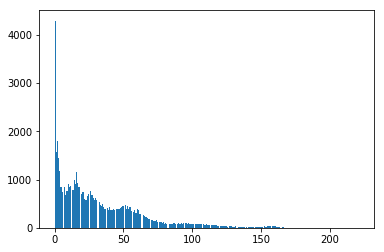

In [17]:
plot_hist(img2)

In [18]:
# 根据上面的 hist 图来选择限制的高度

limit = 1000
img2_che = enhanceContrast.clipped_HE(img2, limit)

In [19]:
img2_bhepl = enhanceContrast.BHEPL(img2)

In [20]:
img2_ahe = enhanceContrast.adaptive_HE(img2)

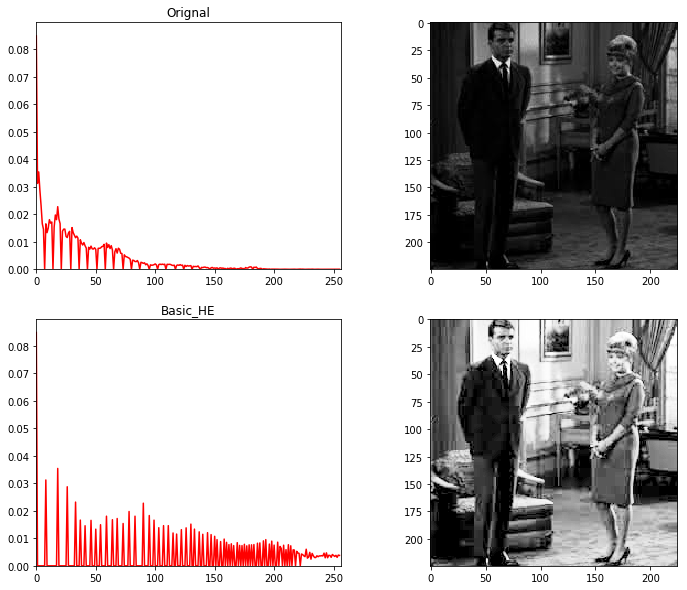

In [21]:
plot_res(img2, img2_he, "Orignal", "Basic_HE")

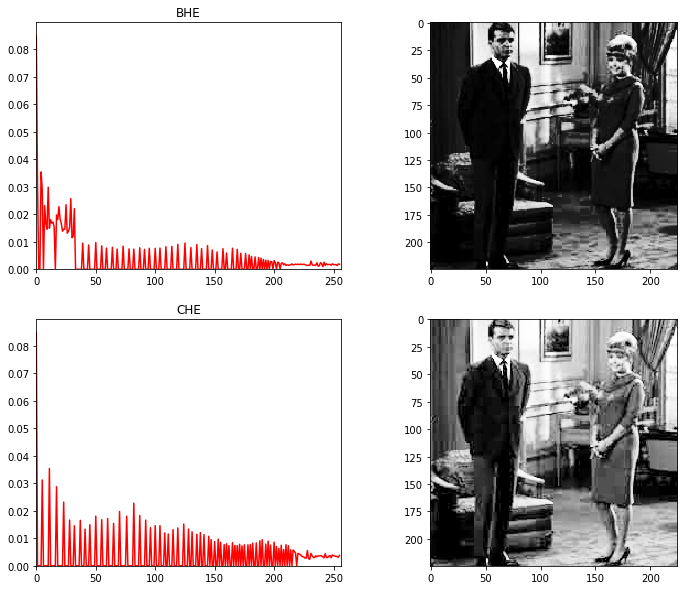

In [22]:
plot_res(img2_bhe, img2_che, "BHE", "CHE")

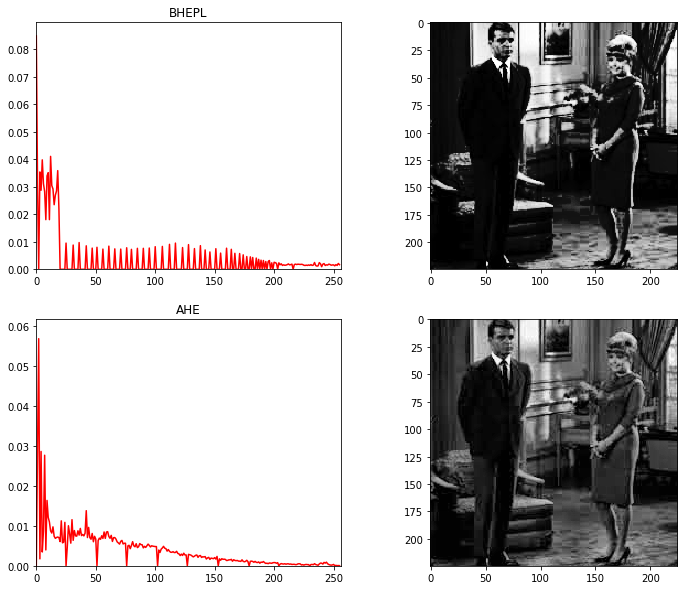

In [23]:
plot_res(img2_bhepl, img2_ahe, "BHEPL", "AHE")

### Example 3

In [24]:
img3 = cv2.imread('girl.jpg', 0)

In [25]:
img3_he = enhanceContrast.basic_HE(img3)

In [26]:
img3_bhe = enhanceContrast.BHE(img3)

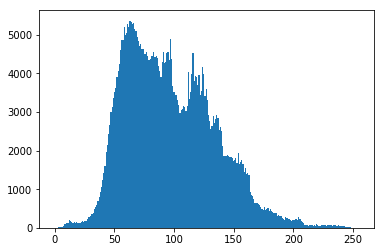

In [27]:
plot_hist(img3)

In [28]:
# 根据上面的 hist 图来选择限制的高度

limit = 3500
img3_che = enhanceContrast.clipped_HE(img3, limit)

In [29]:
img3_bhepl = enhanceContrast.BHEPL(img3)

In [30]:
img3_ahe = enhanceContrast.adaptive_HE(img3)

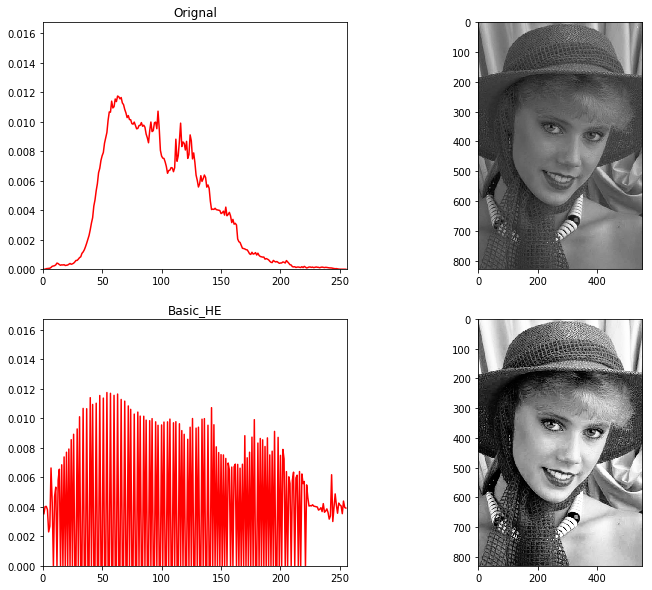

In [31]:
plot_res(img3, img3_he, "Orignal", "Basic_HE")

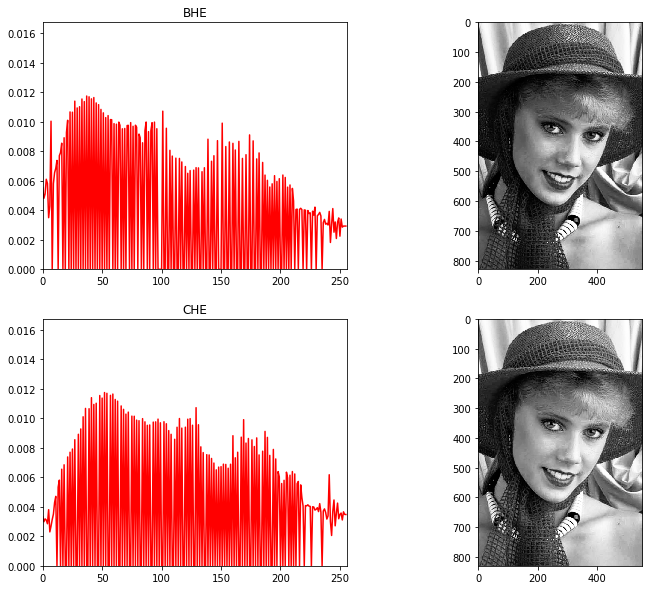

In [32]:
plot_res(img3_bhe, img3_che, "BHE", "CHE")

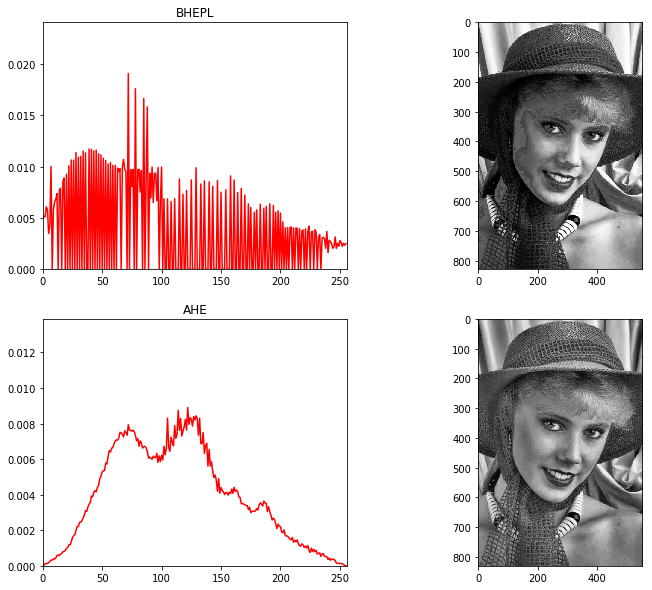

In [33]:
plot_res(img3_bhepl, img3_ahe, "BHEPL", "AHE")